In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os,sys
from PIL import Image
from keras import backend as K

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Loading the dataset

In [3]:
import helper

In [4]:
# Loaded a set of images
root_dir = "Datasets/training/"

n = 100

imgs = []
gt_imgs = []

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
print("Loading " + str(n) + " images")
imgs = [helper.load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [helper.load_image(gt_dir + files[i]) for i in range(n)]

Loading 100 images
Loading 100 images


## Feature processing 

In [5]:
import albumentations as albu

In [6]:
def aug_with_crop(image_size = 256, crop_prob = 1):
    return albu.Compose([
        albu.RandomCrop(width = image_size, height = image_size, p=crop_prob),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.25),
        albu.IAAEmboss(p=0.25),
        albu.Blur(p=0.01, blur_limit = 3),
        #albu.OneOf([
            #albu.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            #albu.GridDistortion(p=0.5),
            #albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)      
        #], p=0.8)
    ], p = 1)

In [7]:
def augment_dataset(imgs, gt_imgs):
    for i in range(100):
        augmented = aug_with_crop(image_size = 400)(image=imgs[i], mask=gt_imgs[i])
        imgs.append(augmented['image'])
        gt_imgs.append(augmented['mask'])

In [8]:
augment_dataset(imgs, gt_imgs)
augment_dataset(imgs, gt_imgs)

In [9]:
len(imgs)

300

In [10]:
idx = 290

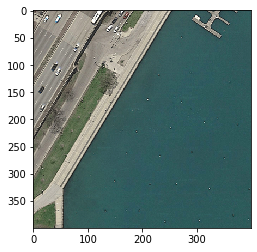

In [11]:
plt.imshow(imgs[idx])

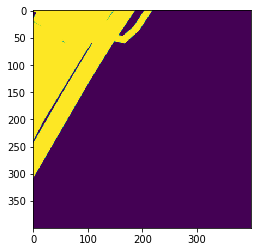

In [12]:
plt.imshow(gt_imgs[idx])

In [13]:
len(imgs)

300

In [14]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

n = 300

img_patches = [helper.img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [helper.img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [15]:
type(imgs[3])

numpy.ndarray

# CNN

In [16]:
from tensorflow.keras import datasets, layers, models

## Layers

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 3)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.summary()

## Training

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y = helper.patches_labelization(gt_patches)
y = to_categorical(y)

model.compile(loss = 'categorical_crossentropy',  optimizer = 'adam', metrics = ['accuracy',f1_m])
h = model.fit(img_patches, y, batch_size = 32, epochs = 4, validation_split = 0.2)

## Predictions

In [19]:
n = 50
patch_size = 16

img_test = []

for i in range(1, 51):
    image_filename = 'Datasets/test_set_images/test_' + str(i) + '/test_' + str(i) + '.png' 
    img_test.append(helper.load_image(image_filename))

img_patches_test = [helper.img_crop(img_test[i], patch_size, patch_size) for i in range(n)]
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

In [57]:
import keras
new_model = keras.models.load_model('saved_M1_fit_SoftmaxCategorical_elastic_15.h5')

In [58]:
predictions = new_model.predict(img_patches_test)

In [59]:
predictions = np.squeeze(helper.binarize_predictions(predictions))

In [60]:
predictions = predictions[:,1]

In [47]:
len(img_test)

50

### Displaying predictions

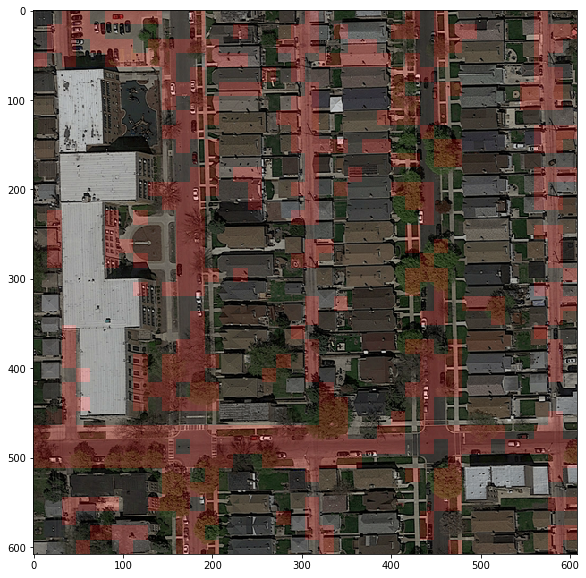

In [61]:
# Display prediction as an image
img_idx = 35
img_indexed = img_test[img_idx]
img_pat = helper.img_crop(img_indexed, patch_size, patch_size)
img_pat = np.asarray(img_pat)
prediction = new_model.predict(img_pat)

prediction = prediction[:,1]

w = 608
h = 608

prediction = helper.binarize_predictions(prediction)
#prediction = single_patch_cleaner(prediction.reshape((w//patch_size, h//patch_size))).flatten()

predicted_im = helper.label_to_img(w, h, patch_size, patch_size, prediction)

cimg = helper.concatenate_images(img_test[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = helper.make_img_overlay(img_test[img_idx], predicted_im)

plt.imshow(new_img)

In [33]:
prediction = helper.single_patch_cleaner(prediction.reshape((w//patch_size, h//patch_size))).flatten()


400

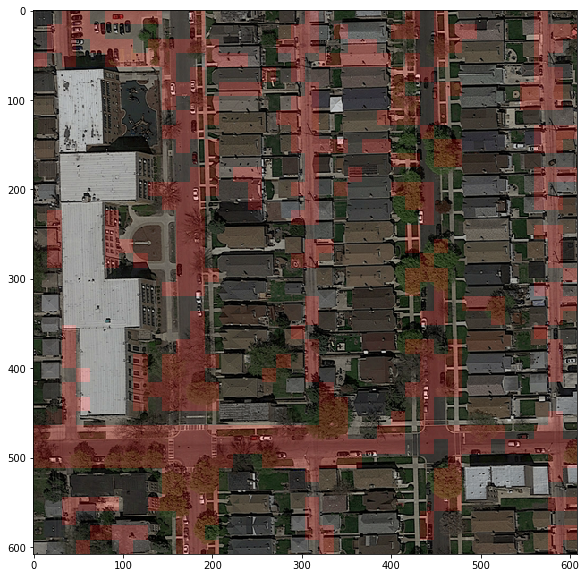

In [63]:
# Display prediction as an image
img_idx = 35
img_indexed = img_test[img_idx]
img_pat = helper.img_crop(img_indexed, patch_size, patch_size)
img_pat = np.asarray(img_pat)
prediction = new_model.predict(img_pat)

prediction = prediction[:,1]

w = 608
h = 608

prediction = helper.binarize_predictions(prediction)
prediction = helper.single_patch_cleaner(prediction.reshape((w//patch_size, h//patch_size))).flatten()

predicted_im = helper.label_to_img(w, h, patch_size, patch_size, prediction)

cimg = helper.concatenate_images(img_test[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = helper.make_img_overlay(img_test[img_idx], predicted_im)

plt.imshow(new_img)

# Create Submission

In [ ]:
import submission as sub

In [ ]:
n = 50
patch_size = 16

img_test = []

for i in range(1, 51):
    image_filename = 'Datasets/test_set_images/test_' + str(i) + '/test_' + str(i) + '.png' 
    img_test.append(helper.load_image(image_filename))

img_patches_test = [helper.img_crop(img_test[i], patch_size, patch_size) for i in range(n)]
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

In [ ]:
predictions = model.predict(img_patches_test)
predictions = np.squeeze(helper.binarize_predictions(predictions))

In [ ]:
predictions = predictions[:,1]

In [ ]:
sub.create_pred_images(predictions, patch_size)

In [ ]:
submission_filename = 'submission.csv'
   
sub.create_submission(submission_filename)

### Displaying predictions

In [ ]:
# Display prediction as an image
img_idx = 49
img_indexed = img_test[img_idx]
img_pat = helper.img_crop(img_indexed, patch_size, patch_size)
img_pat = np.asarray(img_pat)
prediction = model.predict(img_pat)

prediction = prediction[:,1]

w = img_test[img_idx].shape[0]
h = img_test[img_idx].shape[1]

prediction = helper.binarize_predictions(prediction)
prediction = single_patch_cleaner(prediction.reshape((w//patch_size, h//patch_size)))

predicted_im = helper.label_to_img(w, h, patch_size, patch_size, prediction.flatten())
cimg = helper.concatenate_images(img_test[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = helper.make_img_overlay(img_test[img_idx], predicted_im)

plt.imshow(new_img)